In [18]:
import numpy as np
import matplotlib.pyplot as plt
from vertex_model_2d import VertexModel
from voronoi_cells import random_voronoi_cells
def same(x,y):
    return (x and y) or ((not x) and (not y))
def switchaforb(lis,a,b):
    lis[lis.index(a)] = b

In [19]:
class VertexModelApicoBasal:
    def __init__(self, locsb_in, adjs_in, k=1, h=2., A0=1./12, r=1, s=1, boxsizeb = 1.):
        #contains two vertex models, related by curvature.
        locsb = list(np.array(locsb_in).copy())
        adjs_in = list(np.array(adjs_in).copy())
        self.basal_vm = VertexModel(locsb,adjs, boxsize=boxsizeb, A0=1)
        self.K0 = k #dimensionless curvature
        self.A0 = A0
        self.r = r
        self.s = s

        self.thickness = h #thickness has dimensions
        aratio = np.sqrt(1./np.power(1+k,2))
        boxsizea = aratio*boxsizeb
        self.apical_vm = VertexModel([i*aratio for i in locsb],adjs, boxsize=boxsizea, A0=1)

        self.lateralareas = [self.get_lateralarea(i) for i in range(len(self.basal_vm.faces))]

        self.energy = self.combined_energy()

    #dealing with the lateral surface areas:
    def slant_height_ba_vect(self,v1,v2):
        boxsizea = self.apical_vm.boxsize
        boxsizeb = self.basal_vm.boxsize
        
        apical_edge = self.apical_vm.get_edge(v1,v2)
        apical_edgelen = np.linalg.norm(apical_edge)
        apical_midpoint = self.apical_vm.get_vert(v1) + apical_edge/2.
    
        basal_edge = self.basal_vm.get_edge(v1,v2)
        basal_edgelen = np.linalg.norm(basal_edge)
        basal_midpoint = self.basal_vm.get_vert(v1) + basal_edge/2.


        vec_to_midpoint = np.array([boxsizeb/2., boxsizeb/2.]) - basal_midpoint
        apical_mp_trans = apical_midpoint+boxsizea/boxsizeb*vec_to_midpoint
        #put things inside the same periodic-boundary-conditions box
        if apical_mp_trans[0]>boxsizea:
            apical_mp_trans[0]-=boxsizea
        elif apical_mp_trans[0]<0:
            apical_mp_trans[0]+=boxsizea
        if apical_mp_trans[1]>boxsizea:
            apical_mp_trans[1]-=boxsizea
        elif apical_mp_trans[1]<0:
            apical_mp_trans[1]+=boxsizea
        apical_mp_trans = apical_mp_trans-np.array([boxsizea/2.,boxsizea/2.])
        return apical_mp_trans
    def average_edgelen(self,v1,v2):
        apical_edge = self.apical_vm.get_edge(v1,v2)
        apical_edgelen = np.linalg.norm(apical_edge)
    
        basal_edge = self.basal_vm.get_edge(v1,v2)
        basal_edgelen = np.linalg.norm(basal_edge)

        return (apical_edgelen + basal_edgelen)/2.

    def slant_height(self, v1, v2):
        #get the slant height of the lateral contact between vertices v1 and v2
        apical_mp_trans = self.slant_height_ba_vect(v1,v2)
        slant_height = np.sqrt(np.power(self.thickness,2) + np.sum(np.power(apical_mp_trans,2)))
        return slant_height

    def get_lateralarea(self, idx):
        #estimate the lateral surface area for the face with index idx
        face = self.apical_vm.faces[idx]
        boxsizea = self.apical_vm.boxsize
        boxsizeb = self.basal_vm.boxsize
        lateralarea = 0

        for v in range(len(face)):
            v1 = face[v-1]
            v2 = face[v]
            slant_height = self.slant_height(v1,v2)
            average_edgelen = self.average_edgelen(v1,v2)

            lateralarea += average_edgelen*slant_height

        return lateralarea
        #note: the apical and basal surfaces "line up" at the middle of the boxes.

    #mechanical energy
    def combined_energy(self):
        A0 = self.A0
        K0 = self.K0
        r = self.r
        s = self.s

        apical_faceareas = np.array(self.apical_vm.faceareas)
        basal_faceareas = np.array(self.basal_vm.faceareas)
        lateral_faceareas = np.array(self.lateralareas)

        A_tilde =  apical_faceareas + basal_faceareas + lateral_faceareas
        V_tilde = self.thickness*(apical_faceareas + basal_faceareas)/2
        
        K_tilde = np.sqrt(np.divide(apical_faceareas, basal_faceareas)) - 1

        return np.dot(V_tilde-1, V_tilde-1) + np.dot(A_tilde-A0, A_tilde-A0)/r + np.dot(K_tilde-K0, K_tilde-K0)/s

    #convenient terms in the energy gradient
    def del_slant_height_apical(self,v1,v2):
        slh = self.slant_height(v1,v2)
        shvec = self.slant_height_ba_vect(v1,v2)
        return 0.5/slh * shvec
    def del_slant_height_basal(self,v1,v2):
        slh = self.slant_height(v1,v2)
        shvec = self.slant_height_ba_vect(v1,v2)
        return -0.5/slh * shvec

    #gradient descent stuff
    def gradient_one_vertex(self, idx, apical):
        #energy gradient wrt moving one vertex. apical is a flag for whether you're moving the apical vertex.
        A0 = self.A0
        K0 = self.K0
        r = self.r
        s = self.s

        if apical:
            planar_vm = self.apical_vm
        else:
            planar_vm = self.basal_vm
        adj = planar_vm.adj[idx] 
        faceadj = planar_vm.faceadj[idx]
        faces =  map(lambda x: planar_vm.rotate_face(x,idx), faceadj)
        faces = map(lambda x: [faces[x][i] for i in range(len(faces[x])) if faces[x][i] in adj], range(len(faces)))

        gradient = 0
        for f in range(len(faceadj)):
            #compute the contribution to the gradient from each face.
            faceidx = faceadj[f]
            apical_facearea = self.apical_vm.faceareas[faceidx]
            basal_facearea = self.basal_vm.faceareas[faceidx]
            lateral_facearea = self.lateralareas[faceidx]

            A =  apical_facearea + basal_facearea + lateral_facearea
            V = self.thickness*(apical_facearea + basal_facearea)/2
            K = np.sqrt(np.divide(apical_facearea, basal_facearea)) - 1

            Aa = self.apical_vm.faceareas[faceidx]
            Ab = self.basal_vm.faceareas[faceidx]
            
            avg_len_1 = self.average_edgelen(faces[f][0],idx)
            avg_len_2 = self.average_edgelen(faces[f][1],idx)
            
            slh_1 = self.slant_height(faces[f][0],idx)
            slh_2 = self.slant_height(faces[f][1],idx)
            
            del_l1 = planar_vm.del_l(idx,faces[f][0])
            del_l2 = planar_vm.del_l(idx,faces[f][1])

            dA = planar_vm.del_A(idx,faceidx)
            if apical:
                dslh1 = self.del_slant_height_apical(faces[f][0],idx)
                dslh2 = self.del_slant_height_apical(faces[f][1],idx)
            else:
                dslh1 = self.del_slant_height_basal(faces[f][0],idx)
                dslh2 = self.del_slant_height_basal(faces[f][1],idx)

            del_V = self.thickness/2*dA
            del_A = dA + (dslh1*avg_len_1 + slh_1/2.*del_l1) + (dslh2*avg_len_2 + slh_2/2.*del_l2)
            if apical:
                del_K = -0.5*np.power(Ab/Aa,-0.5)*(Ab/np.power(Aa,2))*dA
            else:
                del_K = 0.5*np.power(Ab/Aa,-0.5)*(1/Aa)*dA

            gradient = gradient + 2*(V-1)*del_V + (2./r)*(A-A0)*del_A + (2./s)*(K-K0)*del_K

        return gradient
    def gradient_descent_one_vertex(self,idx, apical, gamma):
        # move a vertex against the energy gradient
        if apical:
            planar_vm = self.apical_vm
        else:
            planar_vm = self.basal_vm

        gradient = self.gradient_one_vertex(idx, apical)
        #print gradient
        
        #update position, edge lengths, face areas in the planar VertexModel
        newpos = planar_vm.v[idx]-gamma*gradient
        for i in range(2):
            if newpos[i]>planar_vm.boxsize:
                newpos[i] -= planar_vm.boxsize
            elif newpos[i]<0:
                newpos[i] += planar_vm.boxsize
        planar_vm.v[idx] = newpos
        planar_vm.edgelens[idx] = map(np.linalg.norm, planar_vm.get_edges(idx))
        for i in planar_vm.faceadj[idx]:
            planar_vm.faceareas[i] = planar_vm.get_facearea(i)
            planar_vm.perims[i] = planar_vm.get_perim(i)

            #update the lateral areas
            self.lateralareas[i] = self.get_lateralarea(i)

        E = self.energy
        self.energy = self.combined_energy()
        #print E-self.energy
        return self.energy-E

    def gradient_descent_step(self, gamma):
        step = 0
        for i in range(len(self.apical_vm.v)):
            step += self.gradient_descent_one_vertex(i, True, gamma)
            step += self.gradient_descent_one_vertex(i, False, gamma)
        return step
    
    def gradient_descent_no_t1(self, gamma, tol):
        step = 2*tol
        while abs(step)>tol:
            step = self.gradient_descent_step(gamma)
            if step>0:
                print 'ascending'
                
    #useful helper functions
    def show_model(self):
        plt.subplot(1,2,1)
        self.basal_vm.show_model()
        plt.title('Basal')
        plt.subplot(1,2,2)
        self.apical_vm.show_model()
        plt.title('Apical')
        plt.show()

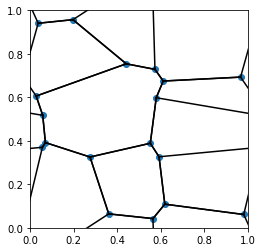

initial energy: 124.787564798


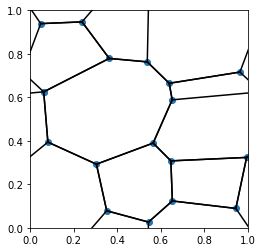

final energy: 114.816028131


In [17]:
vm2d = VertexModel(locs,adjs)
vm2d.show_model()
plt.show()
print 'initial energy:',vm2d.total_mechanical_energy()
vm2d.gradient_descent_no_t1(0.00001,0.00001)
vm2d.show_model()
plt.show()
print 'final energy:',vm2d.total_mechanical_energy()

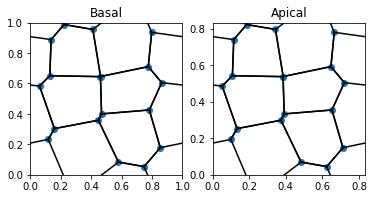

initial energy: 61.6680373429


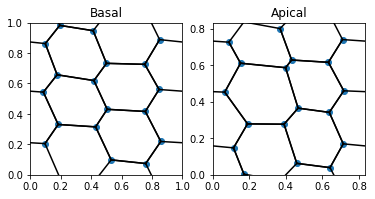

final energy: 59.0884332646


In [20]:
locs,adjs = random_voronoi_cells(3)
vm = VertexModelApicoBasal(locs, adjs, k=0.2)
vm.show_model()
print 'initial energy:',vm.combined_energy()
vm.gradient_descent_no_t1(0.0001,0.0001)
vm.show_model()
print 'final energy:',vm.combined_energy()

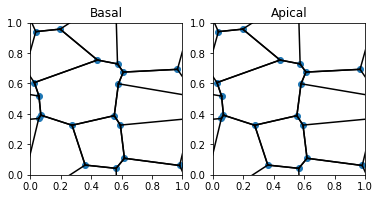

initial energy: 78.2737561332


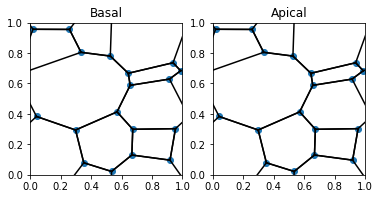

final energy: 72.5602719137


In [10]:
vm = VertexModelApicoBasal(locs, adjs, k=0.)
vm.show_model()
print 'initial energy:',vm.combined_energy()
vm.gradient_descent_no_t1(0.0001,0.0001)
vm.show_model()
print 'final energy:',vm.combined_energy()

In [ ]:
vm = VertexModelApicoBasal(locs, adjs, k=0.4)
vm.show_model()
print 'initial energy:',vm.combined_energy()
vm.gradient_descent_no_t1(0.00001,0.00001)
vm.show_model()
print 'final energy:',vm.combined_energy()

In [ ]:
vm = VertexModelApicoBasal(locs, adjs, k=0.6)
vm.show_model()
print 'initial energy:',vm.combined_energy()
vm.gradient_descent_no_t1(0.0001,0.00005)
vm.show_model()
print 'final energy:',vm.combined_energy()

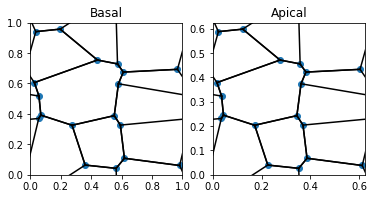

initial energy: 61.3072735476


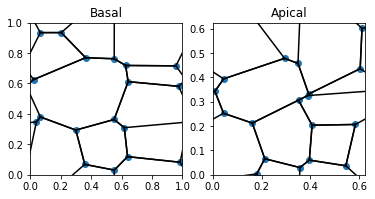

final energy: 59.1019331951


In [15]:
vm = VertexModelApicoBasal(locs, adjs, k=0.6)
vm.show_model()
print 'initial energy:',vm.combined_energy()
vm.gradient_descent_no_t1(0.0001,0.0001)
vm.show_model()
print 'final energy:',vm.combined_energy()

In [3]:
x = [0.2,0.4,0.6,0.8]
y = [6./7,5./7,4./7,3./7,2./7,1./7]
locsb = map(np.array, zip(list(np.meshgrid(x,y)[0].flatten()),list(np.meshgrid(x,y)[1].flatten())))
adjs = [[1,4,20],[0,5,21],[3,6,22],[2,7,23],
       [0,7,8],[1,6,9],[2,5,10],[3,4,11],
        [4,9,12],[5,8,13],[6,11,14],[7,10,15],
        [8,15,16],[9,14,17],[10,13,18],[11,12,19],
        [12,17,20],[13,16,21],[14,19,22],[15,18,23],
        [16,23,0],[17,22,1],[18,21,2],[19,20,3]
       ]

In [4]:
vm = VertexModelApicoBasal(locsb, adjs, k=0.8)

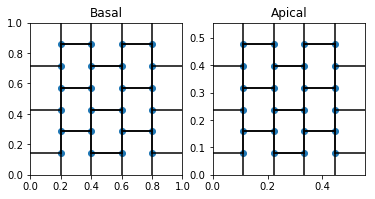

Initial Energy: 70.5601831167


KeyboardInterrupt: 

In [191]:
vm.show_model()
print 'Initial Energy:',vm.combined_energy()
vm.gradient_descent_no_t1(0.00001,0.005)
vm.show_model()
print 'Final Energy:',vm.combined_energy()

In [182]:
print locs, adjs

[array([ 0.93776711,  0.20125304]), array([ 0.91258358,  0.59497458]), array([ 0.71620804,  0.46550154]), array([ 0.75207259,  0.45649155]), array([ 0.69048126,  0.95234836]), array([ 0.8434771,  0.9839626]), array([ 0.90098007,  0.92578616]), array([ 0.68685903,  0.95271956]), array([ 0.64005317,  0.45566106]), array([ 0.5324525 ,  0.32424915]), array([ 0.39578094,  0.87664794]), array([ 0.1039026 ,  0.26192265]), array([ 0.29532312,  0.15870315]), array([ 0.45465057,  0.30361056]), array([ 0.19309994,  0.54375014]), array([ 0.21876962,  0.56542772]), array([ 0.3253142 ,  0.73298654]), array([ 0.32681425,  0.78401995])] [[11, 3, 5], [3, 14, 6], [8, 3, 4], [0, 1, 2], [2, 5, 7], [0, 4, 6], [1, 5, 17], [9, 10, 4], [16, 9, 2], [8, 13, 7], [17, 12, 7], [0, 12, 14], [10, 11, 13], [9, 12, 15], [1, 11, 15], [16, 13, 14], [8, 17, 15], [16, 10, 6]]


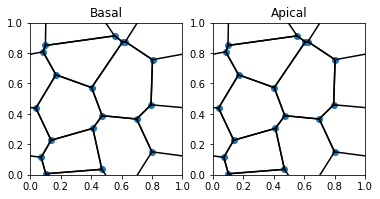

In [194]:
vm = VertexModelApicoBasal(locs, adjs, k=0)
vm.show_model()

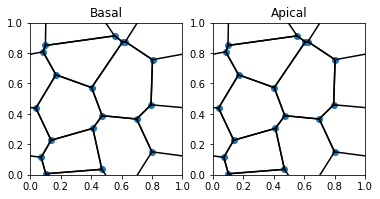

Initial Energy: 74.2413652971


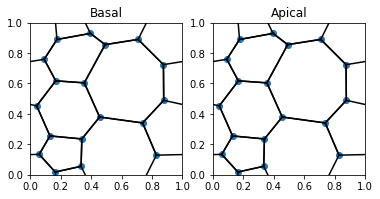

Final Energy: 69.1171504385


In [195]:
vm.show_model()
print 'Initial Energy:',vm.combined_energy()
vm.gradient_descent_no_t1(0.0001,0.001)
vm.show_model()
print 'Final Energy:',vm.combined_energy()

In [62]:
vor.ridge_vertices

[[0, 1], [-1, 0], [-1, 1], [-1, 0], [-1, 1]]

In [65]:
list(vor.vertices)

[array([ 0.78201658,  0.01533864]), array([ 0.72014301,  0.14858919])]

In [64]:
vor.points

array([[ 0.51254925,  0.46850142],
       [ 0.3200376 ,  0.068938  ],
       [ 0.33885911,  0.15643763],
       [ 0.9601752 ,  0.44493959]])

In [147]:
range(-2,2)

[-2, -1, 0, 1]